<a href="https://colab.research.google.com/github/pranavchaudhari0101/-tomatoyolov8model/blob/main/tomato_yolov8_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato Leaf Disease Detection — Ready-to-run Colab

This Colab notebook automates:

- Installing YOLOv8 (ultralytics) and dependencies
- Uploading your `kaggle.json` API key
- Downloading the Kaggle dataset: `farukalam/tomato-leaf-diseases-detection-computer-vision`
- Inspecting dataset structure and converting to YOLO format if needed
- Training a YOLOv8 model (`yolov8n`) and running inference

**Important:** If the Kaggle dataset contains *only* class folders (no bounding-box labels), the notebook will create a single bounding box that covers the entire image for each sample (this treats each image as one object covering the full frame). This is a pragmatic workaround for demonstration, but won't be as accurate as using real bounding-box annotations.

---

Copy this notebook into Google Colab (File → Upload notebook) or download it and open it in Colab.

## ⚠️ Important warning about labels

If the dataset does **not** contain YOLO-format `.txt` label files with bounding boxes, the notebook will automatically create labels that are a single bounding box covering the entire image (i.e. `0 0.5 0.5 1.0 1.0`).

This lets you *experiment* with YOLO training quickly, but it's not a substitute for real bounding-box annotations. If your goal is **accurate object detection** (localizing lesions on leaves), collect or annotate bounding boxes using a labeling tool (LabelImg, VoTT, Roboflow, CVAT, etc.).

If you want a classification approach (predict disease class for full images) instead, tell me and I'll produce a notebook for classification transfer learning (faster and more appropriate if you only have class folders).

In [1]:
# Install required packages
!pip install -q kaggle ultralytics opencv-python-headless matplotlib pandas tqdm seaborn
# show versions
import sys
print('Python', sys.version.splitlines()[0])
import torch, ultralytics, cv2
print('torch', torch.__version__)
print('ultralytics', ultralytics.__version__)
print('cv2', cv2.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00
Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
torch 2.9.0+cu126
ultralytics 8.3.248
cv2 4.12.0


In [2]:
# Upload kaggle.json (click the Choose Files button and upload the kaggle.json you got from Kaggle)
from google.colab import files
import os
uploaded = files.upload()
if 'kaggle.json' not in uploaded:
    print('No kaggle.json uploaded yet. Re-run this cell and upload kaggle.json.')
else:
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json','wb') as f:
        f.write(uploaded['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print('kaggle.json saved to /root/.kaggle/kaggle.json')

Saving kaggle.json to kaggle.json
kaggle.json saved to /root/.kaggle/kaggle.json


In [3]:
# Download the Kaggle dataset. It may take a few minutes.
import os
# Ensure Kaggle config directory is set for the kaggle CLI
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'
!kaggle datasets download -d farukalam/tomato-leaf-diseases-detection-computer-vision -p /content --unzip
# After download, list files
print('Downloaded files in /content:')
print(os.listdir('/content')[:200])

Dataset URL: https://www.kaggle.com/datasets/farukalam/tomato-leaf-diseases-detection-computer-vision
License(s): CC0-1.0
  0% 0.00/23.9M [00:00<?, ?B/s]
100% 23.9M/23.9M [00:00<00:00, 1.25GB/s]
Downloaded files in /content:
['.config', 'README.dataset.txt', 'README.roboflow.txt', 'data.yaml', 'kaggle.json', 'test', 'train', 'valid', 'sample_data']


In [4]:
# Inspect dataset directory structure
import os, glob
base = '/content/Tomato_Leaf_Disease'
if not os.path.exists(base):
    print('Looking for dataset folders in /content:')
    print(os.listdir('/content')[:200])
else:
    for root, dirs, files in os.walk(base):
        print(root)
        print('  subdirs:', dirs[:10])
        print('  files sample:', files[:10])
        break

Looking for dataset folders in /content:
['.config', 'README.dataset.txt', 'README.roboflow.txt', 'data.yaml', 'kaggle.json', 'test', 'train', 'valid', 'sample_data']


In [5]:
# Prepare a working folder and detect label format.
import os, glob
from pathlib import Path

# Determine dataset root (common names)
candidates = ['/content/Tomato_Leaf_Disease','/content/Tomato_Leaf_Diseases', '/content/tomato-leaf-diseases-detection-computer-vision', '/content/PlantVillage', '/content/plant_village']
data_root = None
for c in candidates:
    if os.path.exists(c):
        data_root = c
        break
# fallback: search for folder that contains many jpg/png
if data_root is None:
    for entry in os.listdir('/content'):
        p = os.path.join('/content', entry)
        if os.path.isdir(p):
            count = len(glob.glob(os.path.join(p, '**', '*.jpg'), recursive=True)) + len(glob.glob(os.path.join(p, '**', '*.png'), recursive=True))
            if count > 50:
                data_root = p
                break

if not data_root:
    print('Dataset root not found automatically. After running the previous cell inspect /content and set data_root manually.')
else:
    print('Detected dataset root:', data_root)
    # check for labels in YOLO format
    label_files = glob.glob(os.path.join(data_root, '**', '*.txt'), recursive=True)
    print(f'Found {len(label_files)} .txt files (may include README).')

Detected dataset root: /content/train
Found 645 .txt files (may include README).


In [6]:
# Conversion: If dataset is arranged as class folders with images, convert to YOLO-like detection labels.
# WARNING: This conversion creates a single bbox covering the whole image (x_center=0.5,y_center=0.5,w=1.0,h=1.0).
# This is a fallback for experimentation only.
import os, glob, shutil, random
from pathlib import Path

def convert_class_folders_to_yolo(data_root, out_dir='/content/yolo_data', val_split=0.15, seed=42):
    random.seed(seed)
    os.makedirs(out_dir, exist_ok=True)
    images_train = Path(out_dir) / 'images' / 'train'
    images_val = Path(out_dir) / 'images' / 'val'
    labels_train = Path(out_dir) / 'labels' / 'train'
    labels_val = Path(out_dir) / 'labels' / 'val'
    for p in [images_train, images_val, labels_train, labels_val]:
        p.mkdir(parents=True, exist_ok=True)
    # find class folders directly under data_root
    class_dirs = [d for d in sorted(os.listdir(data_root)) if os.path.isdir(os.path.join(data_root, d))]
    if not class_dirs:
        raise RuntimeError('No class subfolders detected in ' + data_root)
    class_names = class_dirs
    print('Detected classes:', class_names)
    # collect all images with class label
    samples = []
    for class_idx, cls in enumerate(class_dirs):
        cls_path = Path(data_root) / cls
        imgs = list(cls_path.glob('**/*.jpg')) + list(cls_path.glob('**/*.png'))
        for img in imgs:
            samples.append((str(img), class_idx))
    print(f'Found {len(samples)} images across {len(class_dirs)} classes.')
    random.shuffle(samples)
    # split
    n_val = int(len(samples) * val_split)
    val = samples[:n_val]
    train = samples[n_val:]
    def write_samples(list_samples, images_out, labels_out):
        for img_path, class_idx in list_samples:
            fn = Path(img_path).name
            dst_img = images_out / fn
            shutil.copy(img_path, dst_img)
            # create label with full-image bbox
            label_path = labels_out / (Path(fn).stem + '.txt')
            with open(label_path, 'w') as f:
                f.write(f"{class_idx} 0.5 0.5 1.0 1.0\n")
    write_samples(train, images_train, labels_train)
    write_samples(val, images_val, labels_val)
    # write data.yaml
    yaml = Path(out_dir) / 'data.yaml'
    with open(yaml, 'w') as f:
        f.write(f"train: {images_train.absolute()}\n")
        f.write(f"val: {images_val.absolute()}\n")
        f.write(f"nc: {len(class_names)}\n")
        f.write('names: ' + str(class_names) + '\n')
    print('YOLO dataset prepared at', out_dir)
    return str(yaml)

# If dataset root detected earlier, attempt conversion automatically only if no text labels found.
data_root = None
candidates = ['/content/Tomato_Leaf_Disease','/content/Tomato_Leaf_Diseases', '/content/tomato-leaf-diseases-detection-computer-vision', '/content/PlantVillage', '/content/plant_village']
for c in candidates:
    if os.path.exists(c):
        data_root = c
        break
if data_root:
    txts = list(Path(data_root).glob('**/*.txt'))
    imgs = list(Path(data_root).glob('**/*.jpg')) + list(Path(data_root).glob('**/*.png'))
    if len(txts) < len(imgs)/2:
        print('Few/no label .txt files detected. Converting classification folders to YOLO-format dataset with full-image bboxes.')
        yaml_path = convert_class_folders_to_yolo(data_root)
        print('Created data.yaml at', yaml_path)
    else:
        print('Labels appear present in dataset. Please adjust data.yaml manually if needed.')
else:
    print('Data root not detected automatically. Run the inspection cell and set data_root variable manually.')

Data root not detected automatically. Run the inspection cell and set data_root variable manually.


In [7]:
# Show data.yaml if created and preview some images
from pathlib import Path
p = Path('/content/yolo_data/data.yaml')
if p.exists():
    print(p.read_text())
    # show a few validation images (filenames only)
    val_imgs = list(Path('/content/yolo_data/images/val').glob('*.*'))[:6]
    print('Sample val images:', val_imgs)
else:
    print('No /content/yolo_data/data.yaml found. If you have an existing YOLO dataset, set data.yaml path manually.')

No /content/yolo_data/data.yaml found. If you have an existing YOLO dataset, set data.yaml path manually.


In [8]:
# 1. Load the Medium model (More accurate than 'n')
model = ultralytics.YOLO('yolov8m.pt')

# 2. Train with improved settings
results = model.train(
    data='/content/data.yaml',
    epochs=100,              # Increased from 30 to 100
    imgsz=640,
    batch=16,                # If you get 'Out of Memory', change this to 8
    patience=50,             # Wait 50 epochs before stopping if no improvement

    # 3. Augmentations to improve Precision
    mosaic=1.0,              # Combines 4 images (Standard YOLO trick)
    mixup=0.1,               # Blends generic images (Helps reduce false positives)
    degrees=10.0,            # Slight rotation
    fliplr=0.5,              # Left-right flip

    name='tomato_improved_model'
)

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=tomato_improved_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspective=0.0, plots=True,

Using weights: /content/runs/detect/tomato_improved_model/weights/best.pt

image 1/61 /content/valid/images/IMG_0210_JPG.rf.88fef2f797fa888a725ec075a039aa57.jpg: 640x640 (no detections), 37.0ms
image 2/61 /content/valid/images/IMG_0211_JPG.rf.e63eae2f4e0a7ba599feed7fc4dc8436.jpg: 640x640 1 black spot, 37.0ms
image 3/61 /content/valid/images/IMG_0215_JPG.rf.72f64552ad2cd18b9534adce25f54cc5.jpg: 640x640 1 Leaf Mold, 36.0ms
image 4/61 /content/valid/images/IMG_0230_JPG.rf.6aa737da228dfd6ab26b74bbcd84b98e.jpg: 640x640 3 Early_Blights, 4 Leaf Molds, 1 black spot, 33.4ms
image 5/61 /content/valid/images/IMG_0232_JPG.rf.5a3505b99c3a88145e1c842f074c14e4.jpg: 640x640 2 Bacterial Spots, 3 Early_Blights, 3 Leaf Molds, 1 black spot, 33.3ms
image 6/61 /content/valid/images/IMG_0236_JPG.rf.36a3106474d9b044d52908f150163db2.jpg: 640x640 1 Healthy, 33.3ms
image 7/61 /content/valid/images/IMG_0255_JPG.rf.140cd477c07a7f6fcdb21209f97cf11c.jpg: 640x640 4 Early_Blights, 2 Leaf Molds, 2 black spots, 33.3ms
i

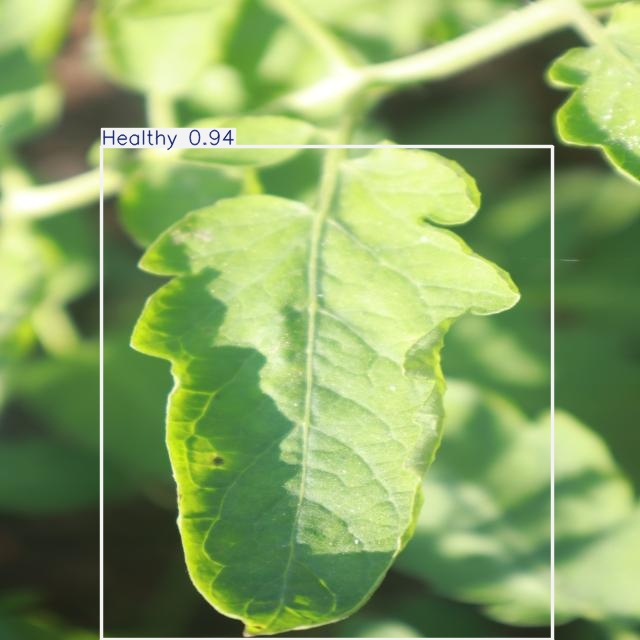

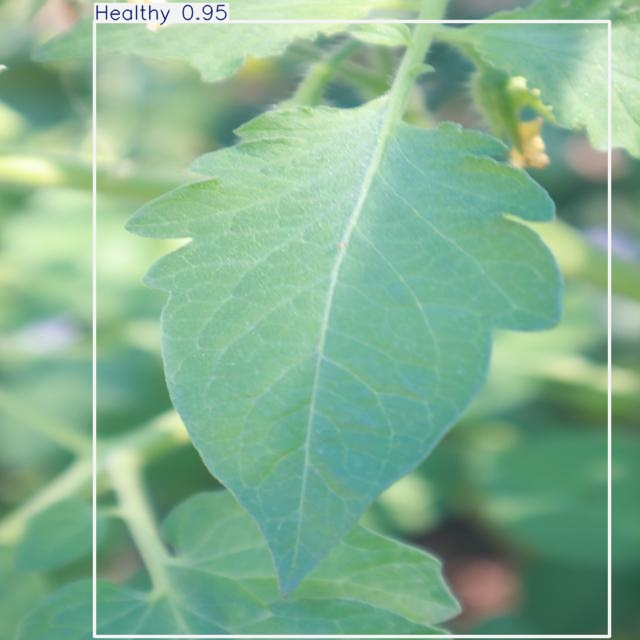

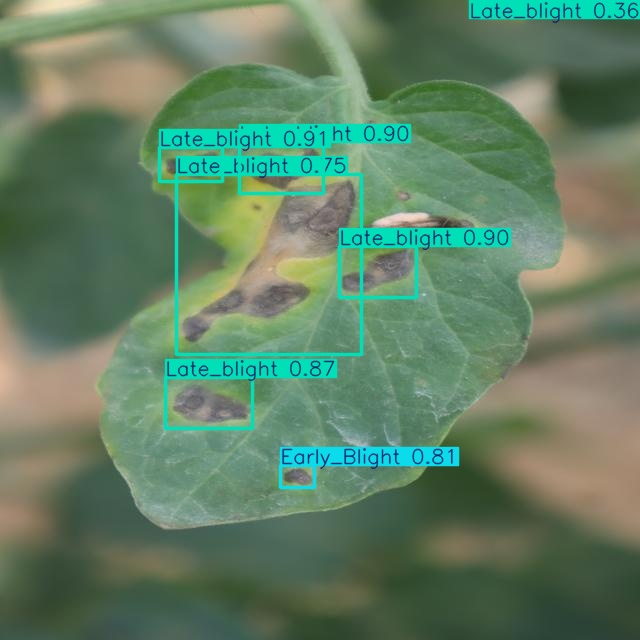

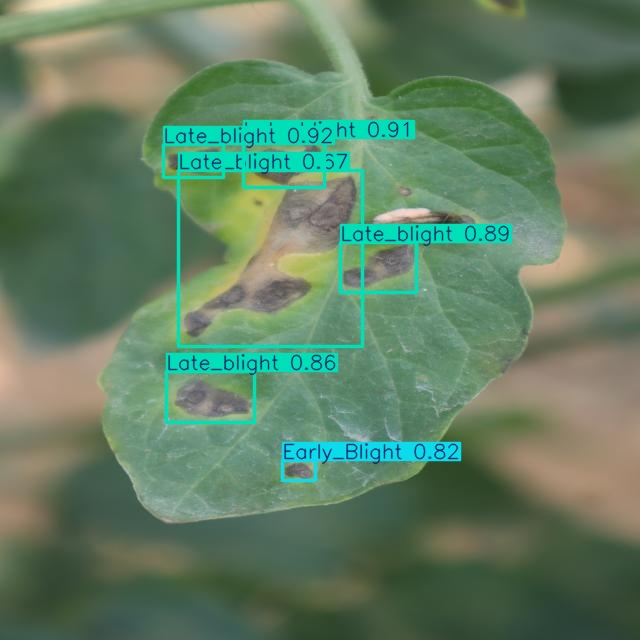

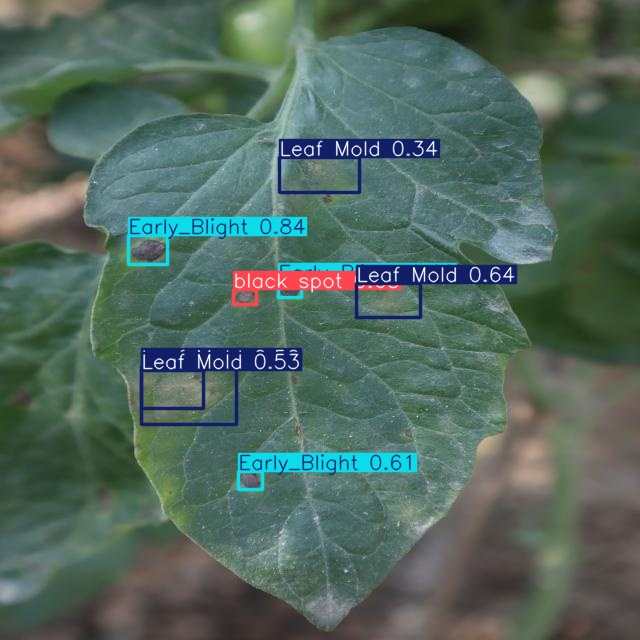

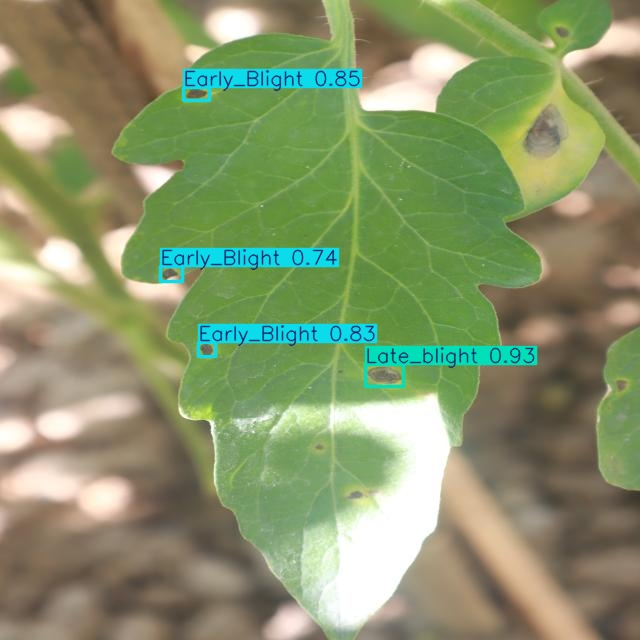

In [11]:
# Run prediction on validation images and display a few results
import glob, os, sys
from ultralytics import YOLO # Import YOLO directly

weights = '/content/runs/detect/tomato_improved_model/weights/best.pt'
if not os.path.exists(weights):
    weights = '/content/runs/detect/tomato_improved_model/weights/last.pt'
print('Using weights:', weights)

# Load a model
model = YOLO(weights) # Load trained weights

# Run inference on the validation set
# The 'predict' method returns a list of Results objects
results = model.predict(source='/content/valid/images', imgsz=640, conf=0.25, save=True, name='predict_val_images')

# show a few prediction images
from IPython.display import Image, display
pred_dir = '/content/runs/detect/predict_val_images'
imgs = glob.glob(pred_dir + '/*.jpg') + glob.glob(pred_dir + '/*.png')
for img in imgs[:6]:
    display(Image(img, width=600))

In [13]:
# Evaluate model on validation set (mAP, precision, recall)
import sys
from ultralytics import YOLO # Import YOLO directly

weights = '/content/runs/detect/tomato_improved_model/weights/best.pt'
if not os.path.exists(weights):
    weights = '/content/runs/detect/tomato_improved_model/weights/last.pt'

# Load a model
model = YOLO(weights) # Load trained weights

# Evaluate the model on the validation set
metrics = model.val(data='/content/data.yaml', imgsz=640)
print(metrics) # Print evaluation metrics

Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 928.6±284.3 MB/s, size: 33.0 KB)
val: Scanning /content/valid/labels.cache... 61 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 61/61 85.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.2it/s 3.5s
                   all         61        196      0.831      0.699      0.755      0.486
        Bacterial Spot          3          4          1       0.71      0.748      0.325
          Early_Blight         31         96       0.81      0.799      0.836      0.476
               Healthy         19         19      0.979          1      0.995      0.948
           Late_blight         13         29      0.865      0.885      0.935      0.738
             Leaf Mold          4          7      0.406      

Saving Screenshot 2025-10-09 095503.png to Screenshot 2025-10-09 095503.png

image 1/1 /content/test_images/Screenshot 2025-10-09 095503.png: 416x640 1 Bacterial Spot, 1 Early_Blight, 1 Late_blight, 48.4ms
Speed: 1.8ms preprocess, 48.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /content/runs/detect/predict
✅ Predictions saved to: /content/runs/detect/predict


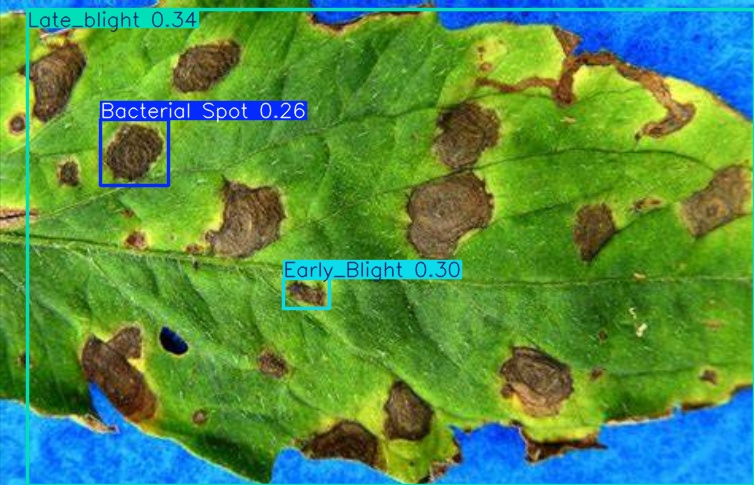

📸 Screenshot 2025-10-09 095503.png
 - Late_blight: 0.34
 - Early_Blight: 0.30
 - Bacterial Spot: 0.26


In [15]:
# --- 🔹 TEST MODEL ON NEW IMAGES MANUALLY ---

from google.colab import files
import os, glob
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt

# 1️⃣ Upload one or more test images
uploaded = files.upload()  # select .jpg or .png images
test_dir = "/content/test_images"
os.makedirs(test_dir, exist_ok=True)
for fn in uploaded.keys():
    os.rename(fn, os.path.join(test_dir, fn))

# 2️⃣ Load your trained YOLOv8 model
model_path = "/content/runs/detect/tomato_improved_model/weights/best.pt"
model = YOLO(model_path)

# 3️⃣ Run prediction
results = model.predict(source=test_dir, conf=0.25, save=True)

# 4️⃣ Display predictions inline
pred_dir = results[0].save_dir
print(f"✅ Predictions saved to: {pred_dir}")

for img_path in glob.glob(os.path.join(pred_dir, "*.jpg")):
    display(Image(filename=img_path, width=600))

# 5️⃣ Optional: show confidence scores for each detection
for r in results:
    print(f"📸 {os.path.basename(r.path)}")
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        name = model.names[cls]
        print(f" - {name}: {conf:.2f}")

### 🧠 To evaluate model accuracy (on your validation set)

In [16]:
# --- 🔹 EVALUATE MODEL ACCURACY (Precision, Recall, mAP) ---
!yolo val model=/content/runs/detect/tomato_yolov8n_experiment/weights/best.pt data=/content/data.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 955, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/models/yolo/model.py", line 76, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 144, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 283, in _load
    self.model, self.ckpt = load_checkpoint(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py", line 1461, in load_checkpoint
    ckpt, weight = torch_safe_load(weight)  # load ckpt
                   ^^^^^^^^^

## Next steps & tips

- If you need accurate bounding boxes, use a labeling tool (LabelImg, CVAT, Roboflow) and re-train with true annotations.
- If the dataset only contains class folders, consider training a classification model (transfer learning) instead — it's often a better fit.
- If you plan to train longer or use larger models, consider saving checkpoints to Google Drive to avoid loss from Colab session timeouts.

If you want, I can also produce a classification notebook (EfficientNet/ResNet transfer learning) that works directly with class folders — say the word and I’ll generate it.